# Installation, data loading, and imports

In [1]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
ID_COLUMN = 'test_id'
THRESHOLD = 'threshold'
SCENARIO_COLUMN = 'scenario'
MODEL_COLUMN = 'model'
SLEEP_ACCURACY_COLUMN = 'sleep_accuracy'
WASA_SLEEP_ACCURACY = [
    0.93, 0.95, 0.97
]
WASA_COLUMN = 'WASA'
AUROC_COLUMN = "AUROC"
ACCURACY_COLUMN = "TST_Error"
EVALUATION_COLUMNS = [AUROC_COLUMN, ACCURACY_COLUMN, WASA_COLUMN,  THRESHOLD, SLEEP_ACCURACY_COLUMN]

# When we analyze the outcomes of our training, 
# we'll stick the data into a pandas dataframe with these columns.
DF_COLUMNS = [ID_COLUMN, SCENARIO_COLUMN, MODEL_COLUMN, *EVALUATION_COLUMNS]

In [3]:
import numpy as np
from typing import List
import tensorflow as tf
import pisces.models as pm
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from typing import List

from tqdm import tqdm

import os
from pathlib import Path

CWD = Path(os.getcwd())
# NB! these are different from preprocess_data.ipynb
save_path = CWD.joinpath("fine_tuning")

hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)



In [4]:
from math import floor


MAX_PSG_EPOCHS = 1024
PSG_EPOCH_SECONDS = 30
PSG_PER_MINUTE = 60 // PSG_EPOCH_SECONDS
ACTIVITY_EPOCH_SECONDS = 15

ACTIVITY_PER_PSG = PSG_EPOCH_SECONDS // ACTIVITY_EPOCH_SECONDS

LR_KERNEL_MINUTES = 15
LR_KERNEL_SIZE = 1 + ACTIVITY_PER_PSG * PSG_PER_MINUTE * LR_KERNEL_MINUTES
LR_ACTIVITY_INPUTS = ACTIVITY_PER_PSG * MAX_PSG_EPOCHS
LR_TOTAL_PAD = (2 * LR_KERNEL_SIZE // 2) - 1
LR_PRE_PAD = floor(LR_TOTAL_PAD / 2)
LR_POST_PAD = LR_TOTAL_PAD - LR_PRE_PAD

LR_INPUT_LENGTH = LR_PRE_PAD + LR_ACTIVITY_INPUTS + LR_POST_PAD
print(f"LR_KERNEL_SIZE: {LR_KERNEL_SIZE}")

# input shapes
smartmap_input_shape = (-1, MAX_PSG_EPOCHS, 4)
lr_input_shape = (-1, LR_INPUT_LENGTH, 1)
label_shape = (-1, MAX_PSG_EPOCHS, 1)

LR_KERNEL_SIZE: 61


# TF Model Definitions

In [5]:
from sklearn.calibration import expit
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom loss function that takes weights into account
def weighted_binary_crossentropy(y_true, y_pred, sample_weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)[..., None]
    weighted_bce = bce * sample_weight
    return tf.reduce_mean(weighted_bce)

# Function to build the CNN-based mixture model
def build_smartmap_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)  # Input shape (1024, 4)

    # First 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='linear')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # # Second 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, padding='same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # x = tf.keras.layers.Dropout(0.1)(x)

    # Output Layer: Binary classification (Wake or Sleep)
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # Logits output! use 'linear' activation for numerical stability
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation='linear')(x)

    # The output shape will be (1024, 1) per example, representing the probability of Sleep at each timestep
    return tf.keras.Model(inputs=inputs, outputs=x)

def cnn_pred_proba(cnn, data):
    return expit(
        cnn.predict(
            data.reshape(1, 1024, 4)
        )).reshape(-1,)

def naive_pred_proba(data):
    return 1 - softmax(data, axis=-1)[:, 0]

In [6]:

# Custom model class
class WeightedModel(tf.keras.Model):
    def __init__(self, original_model):
        super(WeightedModel, self).__init__()
        self.original_model = original_model

    def call(self, inputs):
        x = inputs
        return self.original_model(x)

    def train_step(self, data):
        x, y_true, sample_weight = data

        with tf.GradientTape() as tape:
            y_pred = self.original_model(x, training=True)
            loss = weighted_binary_crossentropy(y_true, y_pred, sample_weight)

        # Compute gradients and update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        return {"loss": loss}

# Original model
def build_lr_cnn(kernel_size: int = LR_KERNEL_SIZE):
    input_layer = layers.Input(shape=(LR_INPUT_LENGTH, 1), name="activity_input")
    x = layers.Conv1D(filters=1, kernel_size=kernel_size, strides=2)(input_layer)
    x = layers.BatchNormalization()(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model

def lr_cnn_pred_proba(lr_cnn, data: tf.Tensor):
    return expit(
        lr_cnn.predict(
            tf.reshape(data, (1, LR_INPUT_LENGTH, 1))
        )).reshape(-1,)
# Create original and weighted models
original_model = build_lr_cnn()
weighted_model = WeightedModel(original_model)

# Compile the model with an optimizer
weighted_model.compile(optimizer='adam', metrics=['auc'])

# Generate dummy data
N_SAMPLES = 5
x_data = tf.random.normal((N_SAMPLES, LR_INPUT_LENGTH, 1), dtype=tf.float32)
y_data = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)
sample_weights = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)

# Train the model using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, sample_weights))
dataset = dataset.batch(1)

# Fit the model
weighted_model.fit(dataset, epochs=2, validation_data=None)


Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415  
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0394 


# Weighting and analysis functions

In [7]:
import sys
sys.float_info.epsilon

2.220446049250313e-16

In [8]:
import json
from dataclasses import dataclass
import sys

import pandas as pd
from sklearn.metrics import auc, roc_curve
from sklearn.utils import class_weight
import numpy as np


def compute_sample_weights(labels: np.ndarray, verbose: bool = False) -> np.ndarray:
    mask_weights = labels >= 0
    if verbose:
        print(f"Scored % of {labels.size} epochs:\n{100 * (np.sum(mask_weights) / mask_weights.size):.2f} ({np.sum(mask_weights)} / {mask_weights.size})")

    class_weight_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=labels[mask_weights].flatten()
    )
    class_weights = {0: class_weight_array[0], 1: class_weight_array[1]}
    if verbose:
        print("Class weights:\n", json.dumps(class_weights, indent=2)) # pretty print
    class_weights |= {-1: 0.0}

    def weight_fn(x):
        return class_weights[x]
    
    wfv = np.vectorize(weight_fn)
    sample_weights = wfv(labels)

    return sample_weights

def compute_mae_for_sleep_time(y_true: tf.Tensor | np.ndarray, y_pred: tf.Tensor | np.ndarray, weights: tf.Tensor | np.ndarray = None) -> float:
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    if isinstance(weights, tf.Tensor):
        weights = weights.numpy()
    # Reshape to simplify processing (remove the singleton dimensions)
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    # Mask out the indices where y_true == -1
    include_sel = weights > 0
    y_true = y_true[include_sel]
    y_pred = y_pred[include_sel]
    
    # Calculate total sleep time (sum of values where label is 1)
    SECONDS_PER_PSG = 30
    SECONDS_PER_MINUTE = 60
    SCALAR = SECONDS_PER_PSG / SECONDS_PER_MINUTE
    
    true_sleep_time = np.sum(y_true == 1)
    pred_sleep_time = np.sum(y_pred == 1)
    # Compute Mean Absolute Error (MAE) for total sleep time
    # mae = tf.abs(SCALAR * (true_sleep_time - pred_sleep_time))
    mae = SCALAR * (true_sleep_time - pred_sleep_time)

    print(f"True sleep time: {true_sleep_time} minutes, predicted {pred_sleep_time} minutes (%E: {mae / true_sleep_time:.2f})")
    
    
    return mae



def masked_weighted_accuracy(y_true, y_pred, sample_weight):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sample_weight = tf.cast(sample_weight, tf.float32)
    correct = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    weighted_accuracy = tf.reduce_sum(correct * sample_weight) / tf.reduce_sum(sample_weight)

    return weighted_accuracy.numpy()

def find_best_threshold(y_true, y_pred, weights, sleep_accuracy, tol: bool = 1e-4):

    threshold_min = 0
    threshold_max = 1
    best_threshold = (threshold_max + threshold_min) / 2
    true_sleep = (y_true == 1) & (weights > 0)
    n_sleep = np.sum(true_sleep)

    just_sleep_pred = y_pred[true_sleep]
    while threshold_max - threshold_min > sys.float_info.epsilon:
        threshold = (threshold_max + threshold_min) / 2
        # only have elements where y_true == 1, i.e. real sleep to score
        y_pred_bin = (just_sleep_pred >= threshold).astype(int)
        # just summing up the 1s, which are "sleep predicted & sleep true"
        accuracy = np.sum(y_pred_bin) / n_sleep
        if accuracy < sleep_accuracy:
            threshold_max = threshold
        else:
            threshold_min = threshold
        if abs(accuracy - sleep_accuracy) < tol:
            break
    best_threshold = (threshold_max + threshold_min) / 2
    print(f"Threshold: {best_threshold}, Accuracy: {accuracy}")

    return best_threshold

def auroc_balaccuracy_wasa(split_name, binary_pred_proba, test_sample_weights, test_labels_masked, sleep_accuracy, verbose: bool = False):
    if isinstance(sleep_accuracy, list):
        return [
            auroc_balaccuracy_wasa(
                f"{split_name}_{int(sleep_accuracy[i] * 100)}",
                binary_pred_proba,
                test_sample_weights,
                test_labels_masked,
                sleep_accuracy[i],
                verbose
            )
            for i in range(len(sleep_accuracy))
        ]

    flat_test_labels = test_labels_masked.reshape(-1,)
    flat_weights = test_sample_weights.reshape(-1,)

    # # compute AUROC
    fpr, tpr, thresholds = roc_curve(flat_test_labels, binary_pred_proba, sample_weight=flat_weights)
    roc_auc = auc(fpr, tpr)

    # # compute WASA
    wasa_threshold = find_best_threshold(
        flat_test_labels,
        binary_pred_proba,
        flat_weights,
        sleep_accuracy
    )#thresholds[np.sum(tpr <= sleep_accuracy)] - 1e-7
    y_guess = binary_pred_proba >= wasa_threshold
    guess_right = y_guess == flat_test_labels
    y_wake = (flat_test_labels == 0) & (flat_weights > 0)
    n_wake = np.sum(y_wake)
    n_wake_right = np.sum(y_wake & guess_right)
    wake_accuracy = n_wake_right / n_wake

    # weighted_accuracy = masked_weighted_accuracy(
    #     flat_test_labels,
    #     y_guess,
    #     flat_weights)
    mae_tst = compute_mae_for_sleep_time(flat_test_labels, y_guess, weights=flat_weights)

    if verbose:
        print("=" * 20)
        print(f"Fold {split_name}")
        print(f"\tROC AUC: {roc_auc}")
        # print(f"\tWEIGHTED accuracy @ ≧{WASA_SLEEP_PERCENT}% sleep: {mae_tst}")
        print(f"\tTotal Sleep Time: {mae_tst}")
        print(f"\t{WASA_COLUMN}: {wake_accuracy} ({n_wake_right} / {n_wake} || threshold: {wasa_threshold})")
        print("=" * 20)
    return roc_auc, mae_tst, wake_accuracy, wasa_threshold


@dataclass
class PreparedData:
    activity: tf.Tensor 
    spectrogram: tf.Tensor 
    mo_predictions: tf.Tensor 
    true_labels: tf.Tensor 
    sample_weights: tf.Tensor 

from pisces.models import load_saved_keras
mo_keras = load_saved_keras()
def mo_predict_logits(data: tf.Tensor):
    return mo_keras.predict(data)

def prepare_data(preprocessed_data: dict):
    keys = list(preprocessed_data.keys())
    xyz_specgram_input = np.array([
        preprocessed_data[k]['spectrogram']
        for k in keys
    ])
    xyz_average = xyz_specgram_input #np.mean(xyz_specgram_input, axis=-1)

    specgram_input = np.zeros((*xyz_average.shape, 2))
    # embed x,y,z into 2 channels
    # one is reflected along the frequency axis
    specgram_input[..., 0] = xyz_average
    specgram_input[..., 1] = xyz_average[..., ::-1]
    
    mo_predictions = mo_predict_logits(specgram_input)

    full_labels = np.array([
        preprocessed_data[k]['psg'][:, 1]
        for k in keys
    ])
    labels = np.where(full_labels > 0, 1, full_labels)

    # in original setup, specgrams were average of x,y,z
    # specgrams = np.mean(xyz_specgram_input, axis=-1)
    specgrams = xyz_specgram_input

    activity = np.array([
        preprocessed_data[k]['activity'][:, 1]
        for k in keys
    ])
    activity = np.pad(activity, ((0, 0), (LR_PRE_PAD, LR_POST_PAD)), mode='constant', constant_values=0)
    weights = np.array([
        compute_sample_weights(labels[i])
        for i in range(labels.shape[0])
    ])
    return PreparedData(
        activity=tf.convert_to_tensor(activity, dtype=tf.float32),
        spectrogram=tf.convert_to_tensor(specgrams, dtype=tf.float32),
        mo_predictions=tf.convert_to_tensor(mo_predictions, dtype=tf.float32),
        true_labels=tf.convert_to_tensor(labels, dtype=tf.float32),
        sample_weights=tf.convert_to_tensor(weights, dtype=tf.float32)
    )


# Plotting functions

In [9]:
from matplotlib import rcParams
import seaborn as sns

color_palette = sns.color_palette("colorblind")

def tri_plot_metrics(
        evaluations_df: List[tuple], 
        accuracy_column: str,
        wasa_column: str,
        auroc_column: str,
        save_dir: Path | None = None, 
        PLOT_TITLE: str = "Metrics", 
        axs: List[plt.Axes] | None = None, 
        axs_set_name: str | None = None, 
        filename: str | None = None,
    ):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig = axs[0].figure

    metrics = {
        'sw_accuracy': evaluations_df[accuracy_column],
        'auc': evaluations_df[auroc_column],
        'wasa': evaluations_df[wasa_column]
    }

    rcParams['font.family'] = 'Helvetica'
    rcParams['font.size'] = 12  # Set a global font size

    metrics_dimensions = {
        # 'sw_accuracy': f'true sleep - pred sleep (min)',
        'sw_accuracy': f'missed sleep (min)',
        'auc': 'AUC',
        'wasa': wasa_column}
    metric_colors = {'sw_accuracy': color_palette[4], 'auc': color_palette[1], 'wasa': color_palette[2]}

    if axs_set_name is not None:
        axs[0].set_title(axs_set_name)

    for metric, ax in zip(metrics_dimensions.keys(), axs):
        sns.histplot(
            metrics[metric],
            bins=20,
            stat='percent',
            kde=True,
            color=metric_colors[metric],
            ax=ax)
        ax.axvline(np.mean(metrics[metric]), color='red', linestyle='dashed', linewidth=2, label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}")
        # ax.set_title(metrics_dimensions[metric])
        ax.set_xlabel(metrics_dimensions[metric])
        if metric != 'sw_accuracy':
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 20)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Customize the remaining spines (left and bottom)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        ax.set_ylabel('% Density')
        ax.legend()

    fig.suptitle(PLOT_TITLE,
                 fontsize=20)
    fig.tight_layout()
    if save_dir is not None:
        if filename is None:
            filename = 'tri_plot_metrics.png'
        fig.savefig(save_dir.joinpath(filename), dpi=600, bbox_inches='tight')

In [10]:

def add_spectrogram(ax, specgram):
    ax.imshow(specgram.T, aspect='auto', origin='lower', vmax=20, vmin=-20)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Specgram')
    ax.set_ylabel('Frequency')

def add_smartmap_inputs(ax, input_data):
    input_t = input_data.T
    INPUT_EPOCHS = input_data.shape[0]
    ax.stackplot(range(INPUT_EPOCHS), softmax(input_t, axis=0))
    ax.set_xlim(0, INPUT_EPOCHS)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'SmartMap Training Input')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_lr_inputs(ax, input_data):
    cnn_input_width = input_data.shape[0]
    ax.plot(range(cnn_input_width), input_data)
    ax.set_xlim(0, cnn_input_width)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Actigraphy')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_hypnogram(ax, binary_pred_proba, true_labels, naive_prediction, model_type, threshold: float | None = None):
    binary_label = 'SmartMap Prediction' if model_type == 'smartmap' else 'LR Prediction'
    ax.plot(binary_pred_proba, label=binary_label)
    if naive_prediction is not None:
        ax.plot(naive_prediction, label='Naive: 1 - P(wake)')

    sample_weight = compute_sample_weights(true_labels)
    masked_true_labels = np.where(sample_weight, true_labels, -1)

    ax.plot(masked_true_labels, label='Actual', linestyle='--')
    if threshold is not None:
        ax.axhline(threshold, color='gold', linestyle='--', label='Threshold: {:.2f}'.format(threshold))
    ax.set_xlim(0, len(binary_pred_proba))
    ax.set_ylabel('Probability of Sleep')
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Hypnogram')
    ax.legend()

    return masked_true_labels, sample_weight


def add_roc(ax, binary_pred_proba, true_labels, sample_weight, naive_prediction: np.ndarray | None = None):
    color_palette = sns.color_palette("colorblind")
    masked_true_labels = np.where(sample_weight, true_labels, 0)
    fpr, tpr, thresholds = roc_curve(masked_true_labels, binary_pred_proba, sample_weight=sample_weight)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    roc_auc_naive = None
    if naive_prediction is not None:
        # Plot the ROC curve from naive_prediction
        fpr_naive, tpr_naive, _ = roc_curve(masked_true_labels, naive_prediction, sample_weight=sample_weight)
        roc_auc_naive = auc(fpr_naive, tpr_naive)
        ax.plot(fpr_naive, tpr_naive, color=color_palette[2], lw=2, label=f'Naive ROC curve (area = {roc_auc_naive:.2f})')
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Wake Predicted as Sleep')
    ax.set_ylabel('Sleep Predicted as Sleep')
    ax.legend(loc="lower right")

    return roc_auc, roc_auc_naive

def ranked_debug_plots(df, eval_data, true_labels, predictors, evaluator, specgrams, filename_suffix: str, model_type: str, split_names: List[str] = None, saveto: Path = None, sortby: str = ACCURACY_COLUMN, sort_ascending: bool = False):
    indices = df.sort_values(sortby, ascending=sort_ascending).index
    aurocs = []
    

    for rank, idx in enumerate(indices):
        if idx >= len(eval_data):
            continue
        row = df.loc[idx]
        split_name = row[ID_COLUMN]
        threshold = row[THRESHOLD]
        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        fig.subplots_adjust(hspace=0, left=0)
        
        # Plot the specgram
        _ = add_spectrogram(axs[0], specgrams[idx])
        
        # Plot the CNN training input as a stacked area plot
        if model_type == 'smartmap':
            add_smartmap_inputs(axs[1], eval_data[idx].squeeze(), )
        elif model_type == 'lr':
            add_lr_inputs( axs[1], eval_data[idx].squeeze(),)
        
        # Plot the final output along with the correct value

        binary_pred_proba = evaluator(predictors[idx], eval_data[idx]).squeeze()
        naive_prediction = 1 - eval_data[idx][:, 0] if model_type == 'smartmap' else None
        masked_true_labels, sample_weight = add_hypnogram(
            axs[2],
            binary_pred_proba,
            true_labels[idx],
            naive_prediction,
            model_type,
            threshold,
        )

        auroc, *_ = add_roc(
            ax=axs[3], 
            binary_pred_proba=binary_pred_proba, 
            true_labels=true_labels[idx], 
            sample_weight=sample_weight, 
            naive_prediction=naive_prediction
        )

        aurocs.append(auroc)

        fig.suptitle(f'#{rank} {split_name} {ACCURACY_COLUMN}: {df.loc[idx, ACCURACY_COLUMN]} {WASA_COLUMN}: {df.loc[idx, WASA_COLUMN]}',
                    fontsize=16, fontweight='bold')
        
        fig.tight_layout(pad=0.1)
        if saveto is None:
            saveto = Path(os.getcwd())
        plt.savefig(saveto.joinpath(f"{split_name}_rank_{rank}_{filename_suffix}.png"))
        plt.close()

    sns.histplot(aurocs, bins=20, kde=True, color='blue', ax=plt.gca(), )
    plt.xlabel('AUROC')
    plt.ylabel('Count')
    plt.title('Distribution of AUROCs')
    plt.show()


# Analysis setup

# Training

## Create data tensors for training + evaluating

In [11]:
dataset = "walch"
walch_preprocessed_data = np.load('./pre_processed_data/walch/walch_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [12]:
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [13]:
walch_data_bundle.mo_predictions.shape

TensorShape([30, 1024, 4])

In [14]:
walch_data_bundle.spectrogram.shape

TensorShape([30, 15360, 32])

## Train LR CNN

In [15]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Set up separate log directories for each model
log_dir_lr = f"./logs/lr_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
log_dir_cnn = f"./logs/cnn_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Configure TensorBoard callback
cnn_tensorboard_callback = TensorBoard(log_dir=log_dir_cnn, histogram_freq=1)
lr_tensorboard_callback = TensorBoard(log_dir=log_dir_lr, histogram_freq=1)

In [16]:

split_maker = pm.LeaveOneOutSplitter()

training_results = []
lr_predictors = []

print("Training LR models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, train_idx_tensor),
        lr_input_shape)
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        label_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        label_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # z-normalize input data
    train_data = (train_data - tf.reduce_mean(train_data)) / np.std(train_data)


    # Custom loss function that includes the sample weights
    lr_cnn = build_lr_cnn()
    weighted_lr_cnn = WeightedModel(lr_cnn)
    weighted_lr_cnn.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (train_data, train_labels_masked, train_sample_weights))
    dataset = dataset.batch(32)
    training_results.append(weighted_lr_cnn.fit(
        dataset,
        epochs=15, 
        verbose=1,
        callbacks=[lr_tensorboard_callback]
    ))


    lr_predictors.append(lr_cnn)

Training LR models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 269353.9688
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -4.2241
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -1.6994
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.8626
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.4538
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2202
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0785
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0066
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0528
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0700
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0636
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0348
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0202
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.1130
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2739


Next split:   3%|▎         | 1/30 [00:00<00:16,  1.81it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 23812.4355
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1563
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8330
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7231
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6668
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6320
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6081
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5906
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5771
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5664
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5576
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5504
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5444
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5393
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5349


Next split:   7%|▋         | 2/30 [00:01<00:14,  1.92it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: -393178.8750
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3826
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2069
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1469
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6166
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2988
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0883
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9399
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8314
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7507
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6909
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6479
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6193
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6037
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6004


Next split:  10%|█         | 3/30 [00:01<00:13,  1.94it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: -240800.4375
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -6.0702
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -2.7888
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -1.6940
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -1.1459
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.8164
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.5960
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.4381
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.3191
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.2262
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1514
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0898
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0381
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0441


Next split:  13%|█▎        | 4/30 [00:02<00:13,  1.95it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: -40604.8984
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -1.0884
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0811
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2474
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4049
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4936
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5496
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5907
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6281
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6708
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7310
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8364
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0957
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0001
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6269


Next split:  17%|█▋        | 5/30 [00:02<00:12,  1.99it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 1829202.8750
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -10.6379
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -4.9975
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -3.1170
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -2.1768
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -1.6126
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -1.2364
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.9676
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.7660
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.6091
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.4836
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.3809
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.2952
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2227
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1605


Next split:  20%|██        | 6/30 [00:03<00:12,  1.98it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: -871221.1875
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.8032
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9885
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3821
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5783
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0958
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7738
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5433
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3698
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2343
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1253
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0355
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9601
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8957
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8400


Next split:  23%|██▎       | 7/30 [00:03<00:11,  1.99it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: -914148.0000
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1424
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9716
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9138
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3849
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0684
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8585
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7097
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5995
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5153
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4498
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3984
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3582
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3271
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3038


Next split:  27%|██▋       | 8/30 [00:04<00:10,  2.02it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: -145369.6719
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9011
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6820
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6060
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0660
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7405
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5225
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3660
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2480
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1559
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0819
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0212
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9705
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9276
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8908


Next split:  30%|███       | 9/30 [00:04<00:11,  1.83it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 192925.3281
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9640
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7377
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6601
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1200
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7950
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5777
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4221
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3051
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2140
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1410
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0812
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0315
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9894
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9535


Next split:  33%|███▎      | 10/30 [00:05<00:10,  1.87it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 15163.2139
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3055
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4060
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4379
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4529
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4611
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4661
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4693
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4715
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4731
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4743
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4752
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4760
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4767
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4774


Next split:  37%|███▋      | 11/30 [00:05<00:10,  1.89it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 51373.2930
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -3.8994
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -1.7072
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.9759
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.6096
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.3893
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2420
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1362
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0565
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0562
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0977
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1327
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1626
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1886


Next split:  40%|████      | 12/30 [00:06<00:09,  1.92it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 72857.5391
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3493
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9632
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4981
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2633
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1209
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0246
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9549
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9019
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8601
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8262
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7981
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7745
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7543
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7369


Next split:  43%|████▎     | 13/30 [00:06<00:08,  1.96it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 16760.6328
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0257
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3884
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5072
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5649
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5982
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6192
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6333
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6429
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6496
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6541
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6572
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6591
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6600
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6603


Next split:  47%|████▋     | 14/30 [00:07<00:08,  1.97it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 145214.2969
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -4.2672
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -1.8786
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -1.0823
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.6839
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.4447
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2849
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1705
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0845
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0173
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0367
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0811
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1184
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1502
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1776


Next split:  50%|█████     | 15/30 [00:07<00:07,  1.99it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: -90438.2656
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0977
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5058
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6414
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7097
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7512
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7790
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7991
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8144
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8264
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8363
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8447
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8522
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8591
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8660


Next split:  53%|█████▎    | 16/30 [00:08<00:06,  2.00it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 64831.1211
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0646
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5130
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3294
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2384
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1839
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1472
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1208
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1008
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0853
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0729
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0628
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0544
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0472
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0410


Next split:  57%|█████▋    | 17/30 [00:08<00:06,  2.00it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 558381.3750
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13.7354
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1057
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8903
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7787
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1086
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6595
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3368
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0933
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9026
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7491
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6227
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5166
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4264
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3487


Next split:  60%|██████    | 18/30 [00:09<00:06,  1.99it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 6472.5938
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6177
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7258
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7599
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7761
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7854
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7909
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7941
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7957
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7962
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7958
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7948
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7933
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7915
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7893


Next split:  63%|██████▎   | 19/30 [00:09<00:05,  2.00it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: -2203665.7500
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9603
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7442
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6698
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6310
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6065
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5893
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5764
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5662
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5579
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5510
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5451
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5401
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5357
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5319


Next split:  67%|██████▋   | 20/30 [00:10<00:05,  2.00it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 690009.7500
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -8.5878
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -3.8897
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -2.3258
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -1.5456
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -1.0788
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.7687
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.5482
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.3842
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2583
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1595
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0808
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0176
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0740


Next split:  70%|███████   | 21/30 [00:10<00:04,  2.01it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 7122.9268
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8918
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0019
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0371
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0537
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0629
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0686
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0724
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0752
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0775
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0797
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0822
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0851
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0887
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0933


Next split:  73%|███████▎  | 22/30 [00:11<00:03,  2.01it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: -98377.9375
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4839
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4749
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4683
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9626
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6574
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4526
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3054
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1942
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1072
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0372
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9797
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9315
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8907
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8556


Next split:  77%|███████▋  | 23/30 [00:11<00:03,  2.02it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 175332.7188
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7736
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1199
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2297
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7815
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5103
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3279
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1964
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0969
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0188
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9559
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9040
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8606
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8237
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7920


Next split:  80%|████████  | 24/30 [00:12<00:02,  2.02it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 44786.0469
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 2.0880
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2700
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9954
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8569
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7730
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7166
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6760
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6454
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6216
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6027
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5872
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5745
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5640
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5552


Next split:  83%|████████▎ | 25/30 [00:12<00:02,  1.86it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 53973.0234
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -1.7323
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.6736
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.3145
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1325
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0220
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0525
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1064
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1474
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1797
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2061
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2281
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2469
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2632
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2776


Next split:  87%|████████▋ | 26/30 [00:13<00:02,  1.90it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: -2502833.2500
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9549
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0251
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3807
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0580
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8643
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7353
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6436
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5757
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5241
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4843
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4537
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4307
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4141
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4035


Next split:  90%|█████████ | 27/30 [00:13<00:01,  1.93it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: -125049.3438
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9468
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4629
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3007
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2194
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1709
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1392
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1176
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1030
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0937
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0890
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0887
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0927
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1016
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1156


Next split:  93%|█████████▎| 28/30 [00:14<00:01,  1.96it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: -48187.6484
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5886
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2818
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1775
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1241
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0917
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0702
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0553
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0451
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0382
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0341
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0325
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0336
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0375
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0445


Next split:  97%|█████████▋| 29/30 [00:14<00:00,  1.96it/s]

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 78687.7812
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3104
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8923
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4169
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1774
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0325
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9351
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8650
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8120
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7707
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7375
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7104
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6878
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6689
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6529


Next split: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


In [17]:
import pandas as pd
from tqdm import tqdm

split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
cnn_predictors = []

print("Training SmartMap models...")
print("Saving models to", walch_path)

def smartmap_gather_reshape(data_bundle: PreparedData, train_idx_tensor: tf.Tensor, input_shape: tuple = smartmap_input_shape, output_shape: tuple = label_shape) -> tuple | None:
    train_data = tf.reshape(
        tf.gather(data_bundle.mo_predictions, train_idx_tensor),
        smartmap_input_shape
        )
    train_labels = tf.reshape(
        tf.gather(data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    return train_data, train_labels, train_sample_weights

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data, train_labels, train_sample_weights = smartmap_gather_reshape(walch_data_bundle, train_idx_tensor)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # Train the model on the training set
    cnn = build_smartmap_model(smartmap_input_shape[1:])
    
    cnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    )

    # gives weight 0 to -1 "mask" intervals, 1 to the rest


    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights,
    # we can just set the labels to 0
    train_labels_masked = np.where(train_sample_weights, train_labels, 0)

    training_results.append(cnn.fit(
        train_data, train_labels_masked, 
        epochs=100, 
        validation_split=0.0, 
        batch_size=1,
        sample_weight=train_sample_weights,
        verbose=0,
        callbacks=[cnn_tensorboard_callback]
    ))


    cnn_predictors.append(cnn)
    # cnn.save(walch_path.joinpath(f"{k_test[0]}_cnn.h5"))




Training SmartMap models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split: 100%|██████████| 30/30 [04:37<00:00,  9.25s/it]


## Hybrid data set

In [18]:
dataset = "hybrid"
hybrid_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [19]:
hybrid_keys = list(hybrid_preprocessed_data.keys())
hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


# Log Reg

# Evaluation

In [20]:
evaluations_df = pd.DataFrame([], columns=EVALUATION_COLUMNS)
scenarios = ['stationary', 'hybrid']
model_types = ['naive', 'smartmap', 'lr']
evals = {s: 
    {m: [] for m in model_types} 
    for s in scenarios
}

for test_idx in range(len(hybrid_preprocessed_data)):
    stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
    stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
    stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
    stationary_binary = naive_pred_proba(stationary_wldm_predictions)
    stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

    hybrid_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    hybrid_labels = walch_data_bundle.true_labels[test_idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)
    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
    hybrid_binary = naive_pred_proba(hybrid_wldm_predictions)
    hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

    # z-normalize input data
    stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
    hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


    # Compute metrics for stationary 
    # Naive 1 - P(wake)
    naive_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        stationary_binary,
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[0]] = naive_eval
    
    # SmartMap
    smartmap_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            stationary_wldm_predictions),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[1]] = smartmap_eval
    
    # LR
    lr_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            stationary_lr_input),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[2]] = lr_eval

    # Compute metrics for hybrid
    # Naive
    naive_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        hybrid_binary,
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[0]] = naive_eval_hybrid
    
    # SmartMap
    smartmap_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            hybrid_wldm_predictions),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[1]] = smartmap_eval_hybrid
    
    # LR
    lr_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            hybrid_lr_input),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[2]] = lr_eval_hybrid
    
    # now append each evaluation to the dataframe, labeled correctly
    evaluations_df = pd.concat([evaluations_df, pd.DataFrame([
            [walch_keys[test_idx], scenario, model, *evals[scenario][model][i], int(100 * WASA_SLEEP_ACCURACY[i])]
            for scenario in scenarios for model in model_types
            for i in range(len(WASA_SLEEP_ACCURACY))
        ], columns=DF_COLUMNS
    )])

Threshold: 0.7191098034381868, Accuracy: 0.9288025889967637
True sleep time: 618 minutes, predicted 649 minutes (%E: -0.03)
Threshold: 0.6748949587345124, Accuracy: 0.9498381877022654
True sleep time: 618 minutes, predicted 672 minutes (%E: -0.04)
Threshold: 0.5806963145732879, Accuracy: 0.970873786407767
True sleep time: 618 minutes, predicted 715 minutes (%E: -0.08)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Threshold: 0.23077411204576503, Accuracy: 0.9288025889967637
True sleep time: 618 minutes, predicted 647 minutes (%E: -0.02)
Threshold: 0.1174272410571574, Accuracy: 0.9514563106796117
True sleep time: 618 minutes, predicted 675 minutes (%E: -0.05)
Threshold: 0.03199902363121521, Accuracy: 0.9692556634304207
True sleep time: 618 minutes, predicted 700 minutes (%E: -0.07)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Threshold: 0.20779060572385777, Accuracy: 0.93042071197411
True sleep time: 618 minutes, predicted 689 minutes (%E: -0.06)
Threshold: 0.1685427799820901, Accuracy: 0.949838187702

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_64975/473102624.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df, pd.DataFrame([


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Threshold: 0.30926035344600666, Accuracy: 0.9301075268817204
True sleep time: 744 minutes, predicted 735 minutes (%E: 0.01)
Threshold: 0.2549881190061568, Accuracy: 0.9502688172043011
True sleep time: 744 minutes, predicted 753 minutes (%E: -0.01)
Threshold: 0.15623816102743138, Accuracy: 0.9704301075268817
True sleep time: 744 minutes, predicted 776 minutes (%E: -0.02)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Threshold: 0.34023500978946697, Accuracy: 0.928763440860215
True sleep time: 744 minutes, predicted 769 minutes (%E: -0.02)
Threshold: 0.3000967651605607, Accuracy: 0.9489247311827957
True sleep time: 744 minutes, predicted 787 minutes (%E: -0.03)
Threshold: 0.2604401558637618, Accuracy: 0.9704301075268817
True sleep time: 744 minutes, predicted 805 minutes (%E: -0.04)
Threshold: 0.7336672842502595, Accuracy: 0.928763440860215
True sleep time: 744 minutes, predicted 741 minutes (%E: 0.00)
Threshold: 0.7268626987934114, Accuracy: 0.94892473118279

# Triplots

In [21]:
evaluations_df.head(10)

,AUROC,TST_Error,WASA,threshold,sleep_accuracy,test_id,scenario,model
0,0.746678,-15.5,0.431818,0.719110,93,1066528,stationary,naive
1,0.746678,-27.0,0.356061,0.674895,95,1066528,stationary,naive
2,0.746678,-48.5,0.128788,0.580696,97,1066528,stationary,naive
3,0.800812,-14.5,0.446970,0.230774,93,1066528,stationary,smartmap
4,0.800812,-28.5,0.340909,0.117427,95,1066528,stationary,smartmap
5,0.800812,-41.0,0.234848,0.031999,97,1066528,stationary,smartmap
6,0.506840,-35.5,0.136364,0.207791,93,1066528,stationary,lr
7,0.506840,-44.0,0.098485,0.168543,95,1066528,stationary,lr
8,0.506840,-52.5,0.068182,0.114084,97,1066528,stationary,lr
9,0.649186,-21.5,0.348485,0.775547,93,1066528,hybrid,naive


In [22]:
WASA_SLEEP_PERCENT = 95
STATIONARY_SET_NAME = "Stationary Data"
HYBRID_SET_NAME = "Hybrid Data"
SECOND_LINE = f"Sleep Accuracy: {WASA_SLEEP_PERCENT}%"
SECOND_TITLE_LINE = f"Comparison of Stationary and Hybrid Data Metrics, {SECOND_LINE}"

## Tri plot for UNet

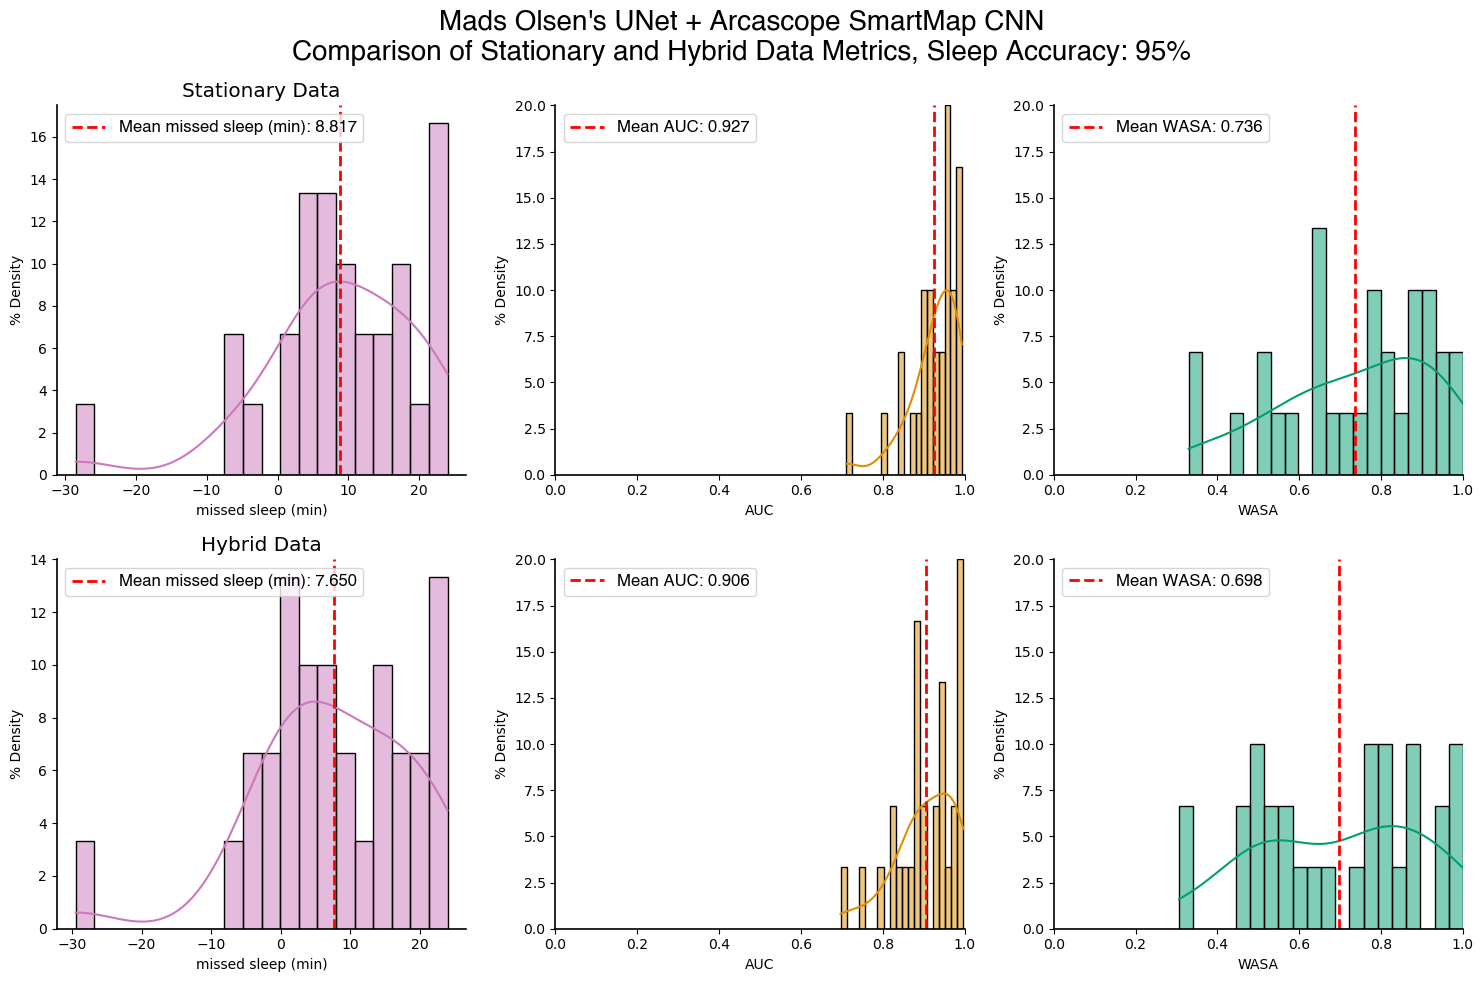

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

cnn_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == 'smartmap']
cnn_evaluations_df = cnn_evaluations_df[cnn_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
cnn_stationary = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == 'stationary']
cnn_hybrid = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == 'hybrid']


tri_plot_metrics(evaluations_df=cnn_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(cnn_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

# for ax in axs.flatten():
#     ax.set_ylim(0, 20)

fig.suptitle(f"Mads Olsen's UNet + Arcascope SmartMap CNN\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"smartmap_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

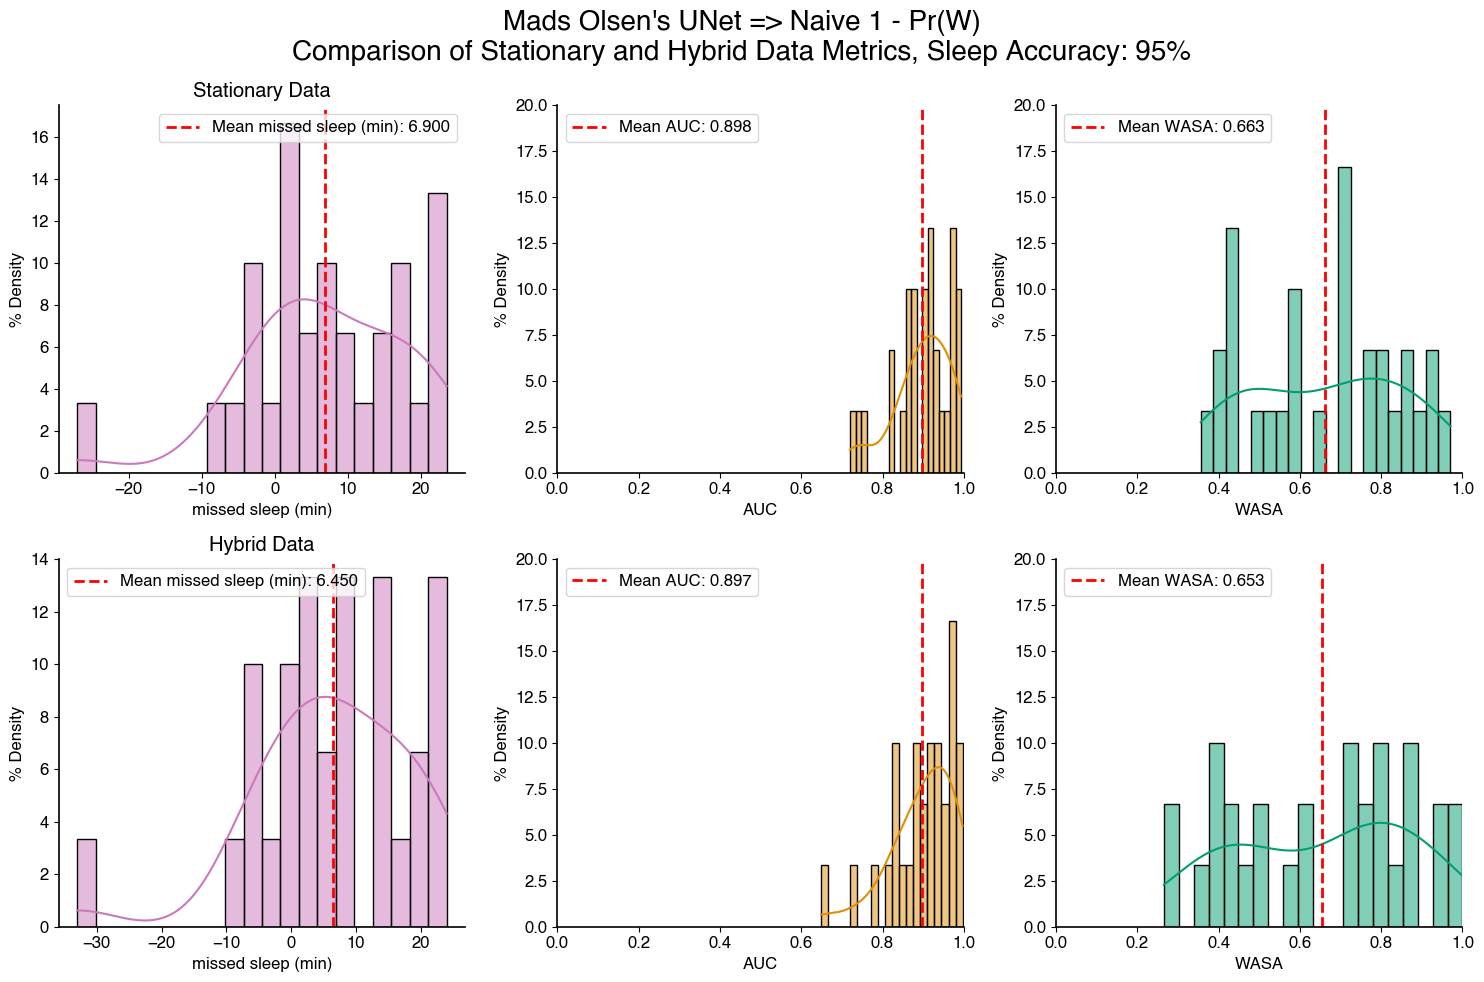

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

naive_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == 'naive']
naive_evaluations_df = naive_evaluations_df[naive_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
naive_stationary = naive_evaluations_df[naive_evaluations_df[SCENARIO_COLUMN] == 'stationary']
naive_hybrid = naive_evaluations_df[naive_evaluations_df[SCENARIO_COLUMN] == 'hybrid']

tri_plot_metrics(naive_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME, 
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(naive_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME, 
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
# for ax in axs.flatten():
#     ax.set_ylim(0, 20)

fig.suptitle(f"Mads Olsen's UNet => Naive 1 - Pr(W)\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"naive_mo_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

## Tri plot for logistic regression CNN

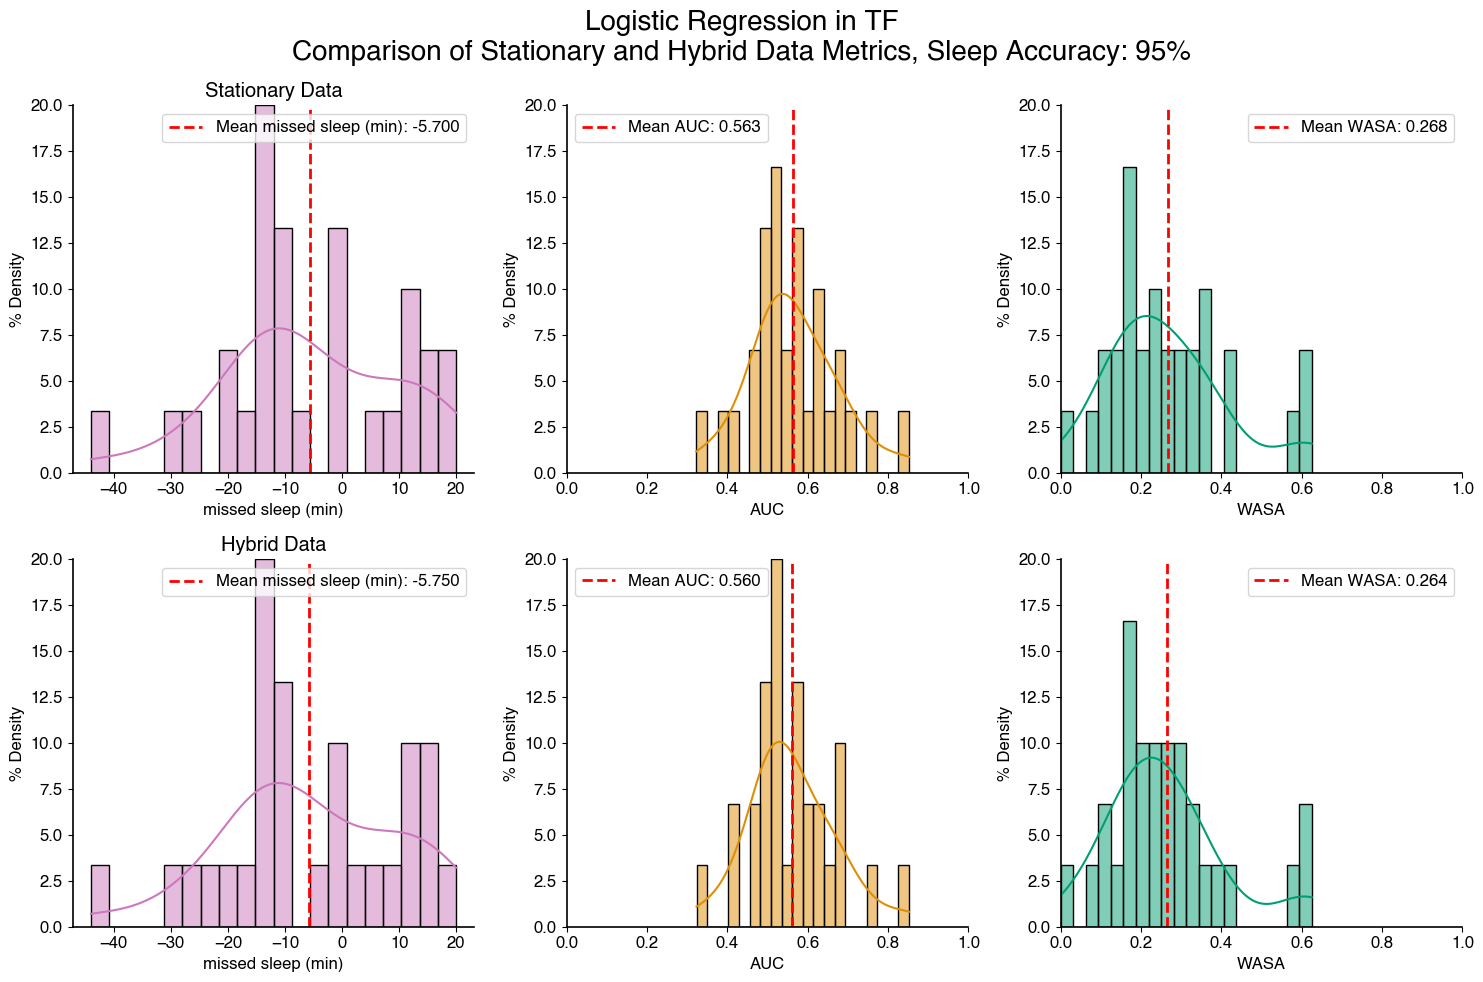

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

lr_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == 'lr']
lr_evaluations_df = lr_evaluations_df[lr_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
lr_stationary = lr_evaluations_df[lr_evaluations_df[SCENARIO_COLUMN] == 'stationary']
lr_hybrid = lr_evaluations_df[lr_evaluations_df[SCENARIO_COLUMN] == 'hybrid']

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Logistic Regression in TF\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"lr_cnn_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')

# Investigate very negative TST Error

In [26]:
evaluations_df.head()

,AUROC,TST_Error,WASA,threshold,sleep_accuracy,test_id,scenario,model
0,0.746678,-15.5,0.431818,0.719110,93,1066528,stationary,naive
1,0.746678,-27.0,0.356061,0.674895,95,1066528,stationary,naive
2,0.746678,-48.5,0.128788,0.580696,97,1066528,stationary,naive
3,0.800812,-14.5,0.446970,0.230774,93,1066528,stationary,smartmap
4,0.800812,-28.5,0.340909,0.117427,95,1066528,stationary,smartmap


In [27]:
evaluations_df_sorted = evaluations_df[evaluations_df['model'] == 'lr'].sort_values(by = 'TST_Error', ascending = False)
evaluations_df_sorted.head()

,AUROC,TST_Error,WASA,threshold,sleep_accuracy,test_id,scenario,model
6,0.556435,30.5,0.400000,0.213489,93,1818471,stationary,lr
15,0.510865,30.0,0.400000,0.208963,93,1818471,hybrid,lr
6,0.697869,26.5,0.440000,0.214844,93,3997827,stationary,lr
15,0.677804,26.5,0.360000,0.214844,93,3997827,hybrid,lr
6,0.680966,26.0,0.588235,0.341309,93,5383425,stationary,lr


In [28]:
scene = 'stationary'
model_t = 'lr'
df_sel = evaluations_df[
    (evaluations_df[SCENARIO_COLUMN] == scene)
    & (evaluations_df[MODEL_COLUMN] == model_t)
    ]
df_sel.reset_index(drop=True, inplace=True)
data_bundle = walch_data_bundle

predictor_dict = {
    'smartmap': cnn_predictors,
    'lr': lr_predictors
}

eval_data_dict = {
    'smartmap': data_bundle.mo_predictions,
    'lr': data_bundle.activity
}

evaluator_dict = {
    'smartmap': cnn_pred_proba,
    'lr': lr_cnn_pred_proba
}

# ranked_debug_plots(
#     df_sel,
#     eval_data_dict[model_t].numpy(),
#     data_bundle.true_labels.numpy(),
#     predictor_dict[model_t],
#     evaluator_dict[model_t],
#     data_bundle.spectrogram.numpy(),
#     f"_tst_eval_{scene}_{model_t}",
#     model_t,
#     walch_keys,
#     sortby=ACCURACY_COLUMN,
#     sort_ascending=False
# )

In [29]:
evaluations_df.to_csv(Path(os.getcwd()).joinpath(f"evaluations_df_{WASA_SLEEP_PERCENT}.csv"), index=False)

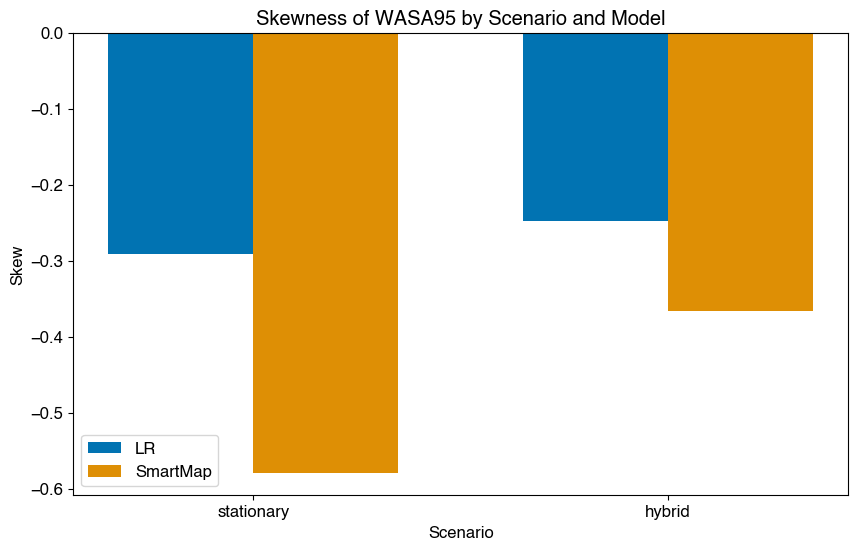

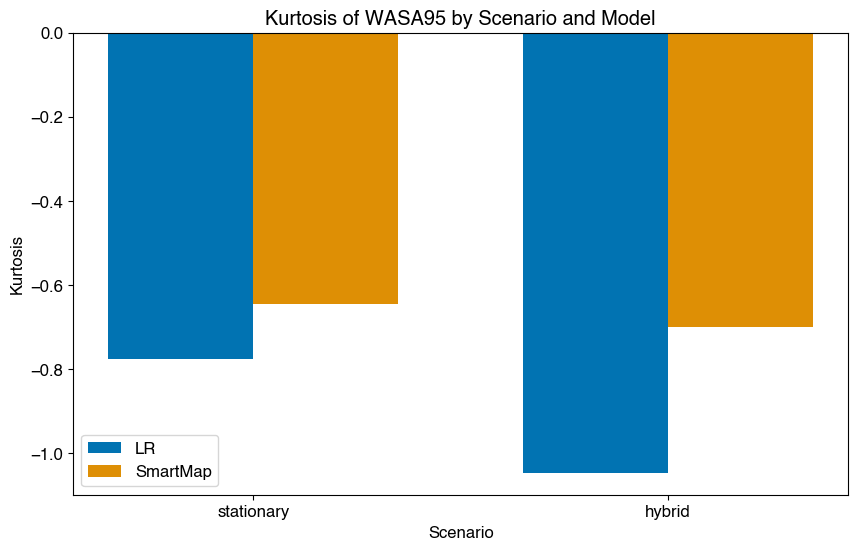

In [30]:
import seaborn as sns
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

smartmap = evaluations_df[evaluations_df['model'] == 'smartmap']
lr = evaluations_df[evaluations_df['model'] == 'lr']
smartmap_wasas = smartmap[WASA_COLUMN]
smartmap_wasas_stationary = smartmap_wasas[smartmap['scenario'] == 'stationary']
smartmap_wasas_hybrid = smartmap_wasas[smartmap['scenario'] == 'hybrid']

lr_wasas = lr[WASA_COLUMN]
lr_wasas_stationary = lr_wasas[lr['scenario'] == 'stationary']
lr_wasas_hybrid = lr_wasas[lr['scenario'] == 'hybrid']

sk_dict = {
    'skew': {m: {} for m in model_types},
    'kurtosis': {m: {} for m in model_types}
}

for scenario in scenarios:
    for model in model_types:
        for stat in ['skew', 'kurtosis']:
            stat_fn = eval(stat)
            sk_dict[stat][model][scenario] = stat_fn(evaluations_df[(evaluations_df['model'] == model) & (evaluations_df['scenario'] == scenario)][WASA_COLUMN])
# Calculate skew and kurtosis for each dataframe
skew_wasa = sk_dict['skew']

kurtosis_wasa = sk_dict['kurtosis']

# Set up data for plotting
# scenarios = list(skew_wasa['lr'].keys())
# models = list(skew_wasa.keys())
skew_values = [[skew_wasa[model][scenario] for scenario in scenarios] for model in model_types]
kurtosis_values = [[kurtosis_wasa[model][scenario] for scenario in scenarios] for model in model_types]

# Define x-axis positions for side-by-side bars
x = np.arange(len(scenarios))
width = 0.35

lr_color = color_palette[0]
smartmap_color = color_palette[1]

# Plot Skewness

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, skew_values[0], width, label='LR', color=lr_color)
plt.bar(x + width/2, skew_values[1], width, label='SmartMap', color=smartmap_color)
plt.xlabel('Scenario')
plt.ylabel('Skew')
plt.title(f'Skewness of WASA{WASA_SLEEP_PERCENT} by Scenario and Model')
plt.xticks(x, scenarios)
plt.legend()
plt.show()

# Plot Kurtosis
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, kurtosis_values[0], width, label='LR', color=lr_color)
plt.bar(x + width/2, kurtosis_values[1], width, label='SmartMap', color=smartmap_color)
plt.xlabel('Scenario')
plt.ylabel('Kurtosis')
plt.title(f'Kurtosis of WASA{WASA_SLEEP_PERCENT} by Scenario and Model')
plt.xticks(x, scenarios)
plt.legend()
plt.show()
